In [1]:
import numpy as np
import random
from matplotlib import pyplot as plt

import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
env = gym.make('CartPole-v0')
input_dim = 4
action_dim = 2

/home/hogun/anaconda2/envs/gym/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [3]:
action_list = [0, 1]

In [4]:
def get_action(q_net, inputs, epsilon, action_dim=11):
    # randomly choose
    if random.random() <= epsilon:
        action_idx = random.randint(0, action_dim-1)
    else:
        q_value = q_net(inputs).tolist()
        action_idx = np.argmax(q_value)
    
    return action_idx

In [5]:
class QNet(nn.Module):
    def __init__(self, input_dim=4, action_dim=2):
        super(QNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
learning_rate = 1e-2
epsilon = 1.0
min_epsilon = 0.01

max_buff_size = 1000
batch_size = 32
gamma = 0.999

In [7]:
q_net = QNet(input_dim, action_dim)
target_net = QNet(input_dim, action_dim)
target_net.load_state_dict(q_net.state_dict())
criterion = nn.MSELoss(reduction='mean')
#optimizer = optim.SGD(q_net.parameters(), lr=1e-6, momentum=0.95)
optimizer = optim.Adam(q_net.parameters(), lr=learning_rate)

#optimizer.zero_grad()

In [8]:
def calculate_loss(minibatch, gamma=0.99):
    rewards = torch.tensor((minibatch[:, 2]).astype(np.float32))
    done = torch.tensor((1-minibatch[:, 4]).astype(np.float32))
    next_q = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, input_dim), dtype=torch.float32))
    next_q_max = next_q[torch.arange(batch_size), next_q.max(1)[1]]
    y_target = rewards + gamma * done * next_q_max
    #print('y target:', y_target)
    q_values = q_net(torch.tensor(np.concatenate(minibatch[:,0], axis=0).reshape(-1, input_dim), dtype=torch.float32))
    actions = minibatch[:, 1].astype(np.int32)
    max_q = q_values[torch.arange(batch_size), actions]
    #print('q:', max_q)
    loss = criterion(y_target, max_q)
    
    return loss

In [9]:
env.reset()

array([ 0.01928016, -0.03572387,  0.00552086,  0.01852299])

In [10]:
replay_buffer = []
log_returns = []
log_minibatchloss = []

done = False
t_step = 0
ridx = 0
episode_reward = 0
observation = env.reset()

while t_step<10000:
    #env.render()
    pre_obs = observation
    input_state = torch.tensor([observation], dtype=torch.float32)
    action_idx = get_action(q_net, input_state, epsilon, action_dim)
    observation, reward, done, info = env.step(action_list[action_idx])
    
    epsilon = max(0.999*epsilon, min_epsilon)
    
    episode_reward += reward
    if done:
        #print('new episode.')
        log_returns.append(episode_reward)
        episode_reward = 0
        observation = env.reset()
    
    if len(replay_buffer)<max_buff_size:
        replay_buffer.append([pre_obs, action_idx, reward, observation, done])
        if len(replay_buffer)<batch_size:
            continue
    else:
        replay_buffer[ridx%max_buff_size] = [pre_obs, action_idx, reward, observation, done]
        ridx += 1
    
    minibatch = np.array(random.sample(replay_buffer, batch_size))
    loss = calculate_loss(minibatch)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (t_step+1)%100==0:
        print(t_step+1, 'step loss:', loss.data.numpy())
    log_minibatchloss.append(loss.data.numpy())
    
    if (t_step+1)%10:
        target_net.load_state_dict(q_net.state_dict())
        
    t_step += 1
    #running_loss += loss.item()

100 step loss: 4347.5938
200 step loss: 23214.545
300 step loss: 633.3142
400 step loss: 231.80997
500 step loss: 64.137184
600 step loss: 45.77886
700 step loss: 31.744955
800 step loss: 17.975775
900 step loss: 22.656235
1000 step loss: 46.83385
1100 step loss: 82.19795
1200 step loss: 8.688998
1300 step loss: 8.949803
1400 step loss: 76.94687
1500 step loss: 85.372604
1600 step loss: 45.07467
1700 step loss: 10.680912
1800 step loss: 5.778859
1900 step loss: 114.459274
2000 step loss: 93.952644
2100 step loss: 39.812817
2200 step loss: 3.36094
2300 step loss: 73.45199
2400 step loss: 76.65194
2500 step loss: 40.74973
2600 step loss: 65.04831
2700 step loss: 2.1639047
2800 step loss: 4.0127983
2900 step loss: 2.4656374
3000 step loss: 1.9911432
3100 step loss: 3.0881987
3200 step loss: 7.7625
3300 step loss: 0.9633869
3400 step loss: 27.8122
3500 step loss: 2.4957805
3600 step loss: 5.8264523
3700 step loss: 6.941495
3800 step loss: 63.80712
3900 step loss: 10.993256
4000 step loss: 

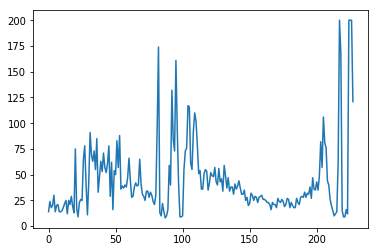

In [11]:
plt.plot(log_returns)

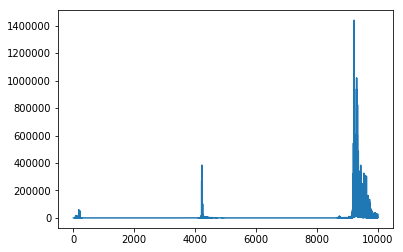

In [12]:
plt.plot(log_minibatchloss)

In [76]:
actions = minibatch[:, 1].astype(np.int32)

In [75]:
actions[1]

4.0

In [79]:
q_values[2, actions[2]]

tensor(0.1348, grad_fn=<SelectBackward>)

In [80]:
actions

array([4, 4, 5, 5, 4, 5, 5, 4, 5, 4, 0, 4, 7, 4, 4, 4, 4, 4, 2, 4, 4, 5,
       4, 4, 4, 5, 5, 4, 4, 5, 4, 5], dtype=int32)

In [72]:
q_values[torch.arange(batch_size), actions]

tensor([-0.0506,  0.2349,  0.1348,  0.0211,  0.2513,  0.3992,  0.0611,  0.1723,
         0.0454, -0.0631, -0.1171, -0.0876, -0.0491,  0.2502, -0.0556, -0.0530,
         0.0613, -0.1380, -0.2137, -0.0490,  0.2368,  0.0771, -0.1257,  0.0239,
        -0.0585,  0.2101,  0.0458, -0.0585, -0.0469,  0.0531,  0.0719,  0.0261],
       grad_fn=<IndexBackward>)

In [61]:
next_q_value

tensor([[-0.3890,  0.2014, -0.2571, -0.0251, -0.0521,  0.4833, -0.7249, -0.0361,
         -0.1900,  0.1108, -0.4397],
        [-0.3219,  0.2305, -0.2084, -0.0083, -0.0382,  0.4465, -0.5485, -0.0122,
         -0.0171,  0.0847, -0.3523],
        [-0.2015,  0.1342,  0.0216, -0.0131,  0.2868, -0.0102, -0.2600, -0.2703,
         -0.3065, -0.1302, -0.1496],
        [-0.2896,  0.2081, -0.1910, -0.0278, -0.0387,  0.3760, -0.5370, -0.0687,
         -0.1798,  0.0376, -0.2814],
        [-0.1036,  0.1037, -0.0619,  0.0192, -0.0147,  0.1950, -0.1751, -0.0594,
          0.0413, -0.0244, -0.0841],
        [-0.1805,  0.1679, -0.1021, -0.0082, -0.0698,  0.1983, -0.3227, -0.0910,
         -0.1269, -0.0140, -0.0550],
        [-0.0927,  0.1206, -0.0480,  0.0112,  0.1465,  0.0464, -0.1083, -0.1965,
         -0.2380, -0.1121, -0.0838],
        [-0.3561,  0.2387, -0.2382, -0.0063, -0.0365,  0.4669, -0.6248, -0.0081,
         -0.0522,  0.0936, -0.4052],
        [-0.2556,  0.1248,  0.0295,  0.0325,  0.3248,  0

In [64]:
next_q_value.max(1)[1]

tensor([5, 5, 4, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 5, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5,
        5, 1, 5, 4, 1, 5, 5, 5])

In [65]:
next_q_max

tensor([ 0.0830,  0.1162, -0.1219,  0.2349,  0.2502, -0.0039, -0.2531,  0.1245,
         0.0834, -0.3718, -0.0237, -0.0529, -0.1929, -0.0046,  0.0380, -0.1818,
        -0.1681, -0.1136, -0.6612, -0.2126, -0.2408,  0.1410, -0.0849,  0.0358,
         0.4429, -0.1297, -0.3034, -0.0631, -0.0349,  0.0212,  0.0593, -0.0207],
       grad_fn=<IndexBackward>)

In [ ]:
rewards = torch.tensor((minibatch[:, 2]).astype(np.float32))
    is_done = torch.tensor((1-minibatch[:, 4]).astype(np.float32))
    next_q_value = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, 3), dtype=torch.float32))
    next_q_max = next_q_value[torch.arange(batch_size), next_q_value.max(1)[1]]
    y_target = rewards + gamma * is_done * next_q_max
#     rewards = torch.tensor(np.expand_dims((minibatch[:, 2]), axis=1).astype(np.float32))
#     is_done = torch.tensor(np.expand_dims((1-minibatch[:, 4]), axis=1).astype(np.float32))
#     next_q_value = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, 3), dtype=torch.float32))
#     next_q_max = next_q_value[torch.arange(32), randn]
#     y_target = rewards + gamma * is_done * next_q_max
    #y_target = np.expand_dims((minibatch[:, 2]), axis=1) + gamma * np.expand_dims((1-minibatch[:, 4]), axis=1) * target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, 3), dtype=torch.float32)).detach().numpy()
    q_values = q_net(torch.tensor(np.concatenate(minibatch[:,0], axis=0).reshape(-1, 3), dtype=torch.float32))
    actions = minibatch[:, 1].astype(np.int32)
    max_q_values = q_values[torch.arange(batch_size), actions]
    loss = criterion(y_target, max_q_values)

In [32]:
next_q = target_net(torch.tensor(np.concatenate(minibatch[:,3], axis=0).reshape(-1, 3), dtype=torch.float32))

In [42]:
randn = torch.randint(11, [32])
randn

tensor([ 9,  1,  7,  4,  4,  7,  6,  4,  1,  0,  3, 10,  2,  2,  9, 10,  8,  8,
         6,  2,  8,  4,  2, 10,  5,  8,  6,  4,  7,  1,  3,  3])

tensor([-0.0313, -0.1489,  0.2202,  0.1781,  0.2679,  0.2032, -0.2715,  0.2581,
        -0.0288,  0.1414, -0.0444,  0.4045, -0.2039, -0.0605,  0.0135,  0.3185,
         0.0863, -0.0968, -0.1068,  0.1083,  0.0934,  0.1778, -0.2150,  0.3657,
        -0.2678,  0.1024, -0.1340,  0.2576,  0.1774, -0.1080,  0.0210,  0.0256],
       grad_fn=<IndexBackward>)

In [46]:
torch.arange(10)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
next_q.max(1)[1]

tensor([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [82]:
minibatch[:, 2]

array([-9.304452611223322, -10.277520192779392, -7.663879315635071,
       -4.122275127762492, -4.864194751165726, -6.69305600017488,
       -6.831440050666521, -6.662494135081751, -6.498908856451996,
       -10.490003068554401, -3.931196337876829, -6.50953319594097,
       -7.578516737689235, -5.718443140197207, -4.662344422291226,
       -7.430904266226308, -2.5485305567021013, -6.450659765574713,
       -8.684033564167008, -9.684042348838389, -9.052098908335038,
       -10.629917792859263, -8.268540220360256, -7.221282443741913,
       -10.835569799761178, -3.3383065107372225, -8.690510126735012,
       -2.880008231737317, -9.793632228859387, -8.01807854930547,
       -5.527274318559685, -3.504413498124011], dtype=object)

In [76]:
np.expand_dims((minibatch[:, 2]), axis=1)

array([[-9.304452611223322],
       [-10.277520192779392],
       [-7.663879315635071],
       [-4.122275127762492],
       [-4.864194751165726],
       [-6.69305600017488],
       [-6.831440050666521],
       [-6.662494135081751],
       [-6.498908856451996],
       [-10.490003068554401],
       [-3.931196337876829],
       [-6.50953319594097],
       [-7.578516737689235],
       [-5.718443140197207],
       [-4.662344422291226],
       [-7.430904266226308],
       [-2.5485305567021013],
       [-6.450659765574713],
       [-8.684033564167008],
       [-9.684042348838389],
       [-9.052098908335038],
       [-10.629917792859263],
       [-8.268540220360256],
       [-7.221282443741913],
       [-10.835569799761178],
       [-3.3383065107372225],
       [-8.690510126735012],
       [-2.880008231737317],
       [-9.793632228859387],
       [-8.01807854930547],
       [-5.527274318559685],
       [-3.504413498124011]], dtype=object)